In [1]:
import numpy as np
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from keras.preprocessing import image
from keras.models import load_model
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.constraints import maxnorm
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

<b>Нормализуем, чтобы значения были от 0 до 1</b>

In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

<b>Применим one-hot encode</b>

In [4]:
y_train_ohe = keras.utils.to_categorical(y_train, 10)
y_test_ohe = keras.utils.to_categorical(y_test, 10)

<b>Выведем несколько фотографий</b>

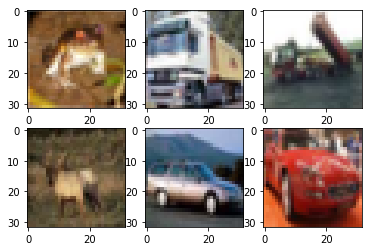

In [5]:
for i in range(6):
    plt.subplot(231+i)
    plt.imshow(x_train[i])

<br>Пулинг уплотняет карту пикслей до одного. В нашем случае размер карты будет 2х2, что является стандратным значением.</br>
<br>В качестве слоя активации будем использовать relu, так как она проще тангеса или сигмоиды и ускоряет обучение.</br>
Дропаут помогает избавиться от переобучения, избавляясь от взаимоадаптации нейронов.

In [6]:
def Model():
    #Линейный стек слоев
    model = Sequential()
    # Новая карта получается того же размера (padding='same')
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                     activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    # Выполянем пулинг с размером 2x2 (стандартно)
    # Нам необходимо уменьшить размерность карты
    # Так как на предыдущей операции мы определили какие-то признаки, то далее они нам ненужны
    # Поэтому мы их исключаем и это помогает не переобучаться
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Дропаут с вероятностью 25% 
    model.add(Dropout(0.25))
   
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    # Полносвязный слой, который является слоем многослойного персептрона
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    # Оптимизируем с помощью стохастиеского градиентного спуска, используя метод Нестерова
    optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [7]:
def plot_loss_acc(model):
    plt.figure(0)
    plt.plot(model.history['acc'],'r')
    plt.plot(model.history['val_acc'],'g')
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(['train','test'])
    
    plt.figure(1)
    plt.plot(model.history['loss'],'r')
    plt.plot(model.history['val_loss'],'g')
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(['train','test'])
 
    plt.show()

Напишем функцию, которая будет предсказывать категорию фотографии с помощью натренированной модели.

In [8]:
def predict(modelName, imagePath):
    classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
    my_mod = load_model(modelName)
    x = image.load_img(imagePath, target_size=(32,32))
    x = image.img_to_array(x)
    x = x.reshape((1,) + x.shape)
    x = x/255.
    pr=my_mod.predict(x.reshape(-1,32,32,3))
    print('На картинке', classes[int(np.argmax(pr, axis=1))])

Инициализируем нашу модель и обучим на 50 эпохах

In [9]:
model = Model()
batch_size = 32
epochs = 50
model.summary()
history = model.fit(x_train, y_train_ohe, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(x_test, y_test_ohe))
 
model.evaluate(x_test, y_test_ohe)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

[0.8024249540328979, 0.7415]

Построим график кривых accuracy и loss

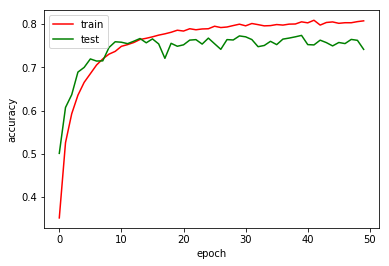

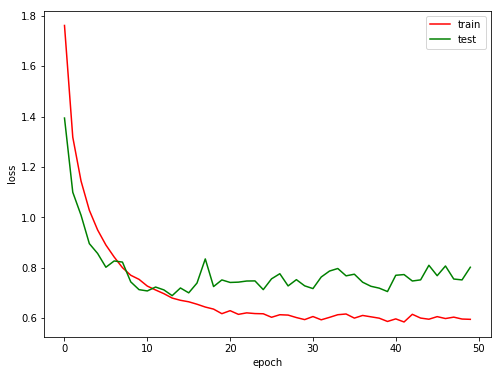

In [10]:
plot_loss_acc(history)

<br>Как мы видим, междву кривыми есть разница, это указывает на то, что наша сеть немного переобучилась.</br>
<br>Мы уже использовали дропаут, чтобы уменьшить дисперсию. Поэтому нам необходимо получить больше данных для обучения. </br>
<br>Мы воспользуемся аугментацией данных. Т.е. мы добавим новых данных путем изменения старых (поворот, увеличение, растяжение и т.д.)</br>
<br>Это должно помочь нам уменьшить переобучение.</br>

In [11]:
AugData = ImageDataGenerator(
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)

In [12]:
model_1 = Model()
batch_size = 256
epochs = 50
model_1.summary()
history_1 = model_1.fit_generator(AugData.flow(x_train, y_train_ohe, batch_size=batch_size), steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))), 
                                  epochs=epochs, verbose=1, 
                   validation_data=(x_test, y_test_ohe), workers=4)
 
model_1.evaluate(x_test, y_test_ohe)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
__________

[0.5971691155910492, 0.7949]

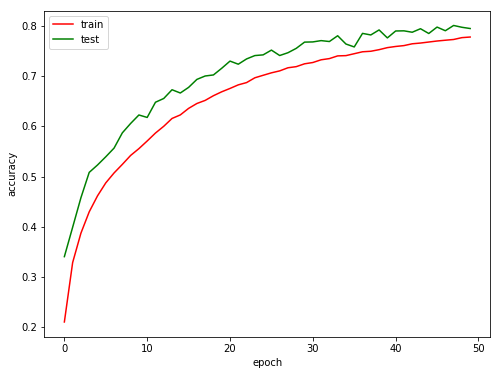

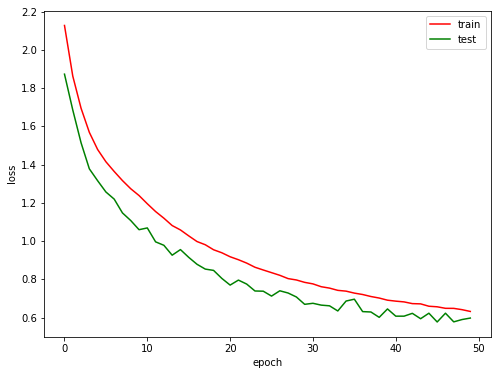

In [13]:
plot_loss_acc(history_1)

Ситуация улучшилась и мы видим, что наша сеть научилась обобщать гораздо лучше.

Однако, можно попробовать еще больше улучшить результат.

In [14]:
model_2 = Model()
batch_size = 256
epochs = 120
model_2.summary()
history_2 = model_2.fit_generator(AugData.flow(x_train, y_train_ohe, batch_size=batch_size), steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))), 
                                  epochs=epochs, verbose=1, 
                   validation_data=(x_test, y_test_ohe), workers=4)
 
model_2.evaluate(x_test, y_test_ohe)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
__________

[0.4714893337249756, 0.8386]

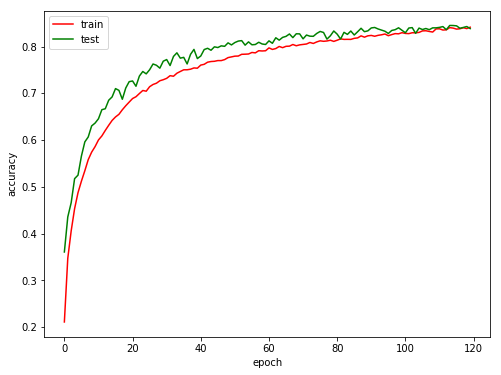

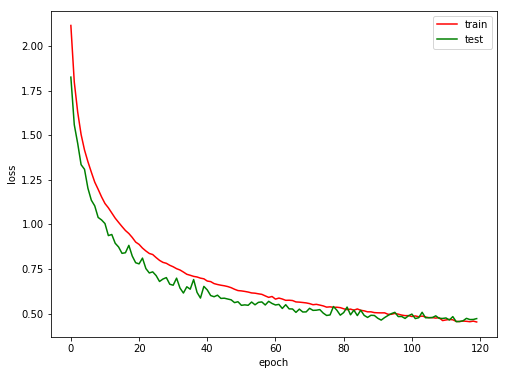

In [15]:
plot_loss_acc(history_2)

<br>Добавим еще два сверточных слоя. Будем использовать регуляризацию ядра l2</br>
<br>Вместо функции активации ReLU будем использовать ELU</br>
$$f(\alpha,x)=\left\{\begin{matrix}
 \alpha(e^x-1), \ x < 0& \\ 
  x, \ x\geqslant 0 & 
\end{matrix}\right.$$

<br>Еще добавим BatchNormalization для ускорения обучения.</br>
Вместо SGD будем использовать его модификацию rmsprop

In [16]:
def Model_v2():
    weight_decay = 1e-4
    
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                     activation='elu', kernel_regularizer=regularizers.l2(weight_decay),
                     input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='elu',
                    kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2))) 
    model.add(Dropout(0.2))
   
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',
                    kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',
                    kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='elu',
                     kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='elu',
                     kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    optimizer = rmsprop(lr=0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [17]:
def lr(epochs):
    lrate = 0.001
    if epochs > 75:
        lrate = 0.0005
    elif epochs > 100:
        lrate = 0.0003        
    return lrate

In [18]:
model_3 = Model_v2()
batch_size = 256
epochs = 120
model_3.summary()
AugData.fit(x_train)
history_3 = model_3.fit_generator(AugData.flow(x_train, y_train_ohe, batch_size=batch_size), steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))), 
                                  epochs=epochs, verbose=1, 
                   validation_data=(x_test, y_test_ohe), workers=4, callbacks=[LearningRateScheduler(lr)])
 
model_3.evaluate(x_test, y_test_ohe)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)        18496     
__________

[0.40969091095924376, 0.8956]

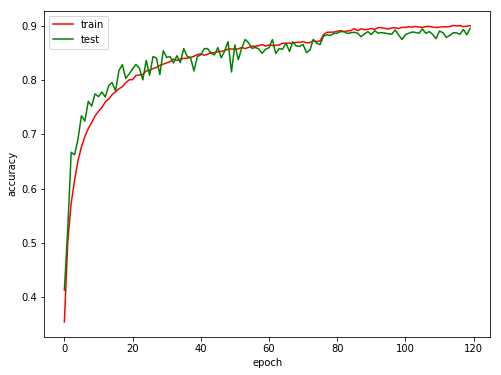

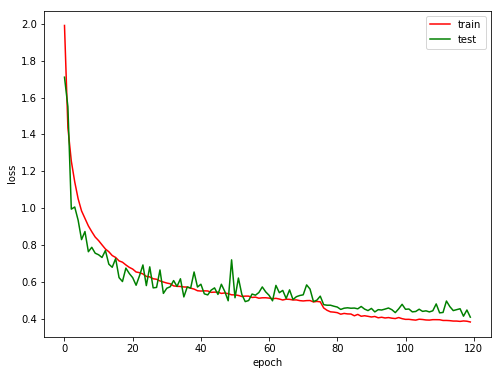

In [19]:
plot_loss_acc(history_3)

Мы смогли добиться примерно 90% точности.